# Homework 2
## This jupyter notebook is also accessble as an online colab notebook : https://colab.research.google.com/drive/10KcuDSp9jCx0eFkdQ-UvrS6VPQjmpYPQ#scrollTo=Yj8OAlyA5Tzv

## Q1

### Load & normalize the data

    0         1         2         3   ...        32        33        34        35
0  NaN  1.000000  0.694047  0.427273  ...  0.610156  0.651456  0.231579  0.158984
1  NaN  0.890850  0.196389  0.150320  ...  0.796417  0.839826  0.307227  0.141549
2  1.0  0.928588  0.771404  0.364708  ...  0.283042  0.448587  0.113400  0.002494
3  NaN  0.695489  0.229246  0.113419  ...  0.839346  0.831158  0.678270  0.437713
4  NaN  0.567578  0.280369  0.081376  ...  0.553549  0.451600  0.123776  0.000000

[5 rows x 36 columns]


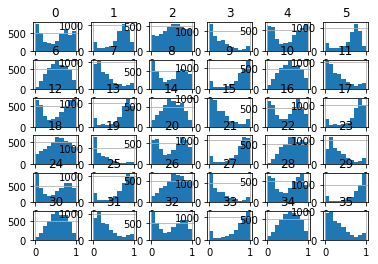

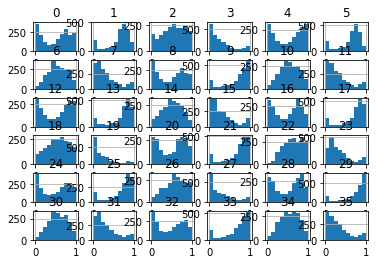

In [0]:
import pandas as pd
import numpy as np
from urllib.request import urlopen
import re
from sklearn import preprocessing

data_train = urlopen("https://raw.githubusercontent.com/peterwu19881230/CSCE633_ML_data/master/satimage.scale.training") # it's a file like object and works just like a file
data_test = urlopen("https://github.com/peterwu19881230/CSCE633_ML_data/raw/master/satimage.scale.t") # it's a file like object and works just like a file  
#Note for the test data: 1. I manually deleted a "NUL" on line 1181 1. I manually deleted a new line character at the end of the file

def parse_data(data):
  rows=[]
  class_=[]
  for line in data: # files are iterable
      
      string=line.decode("utf-8").rstrip() #rstrip() is to trim EOL
      words=string.split(sep=" ")
      

      class_.append(words[0])

      words.pop(0) #remove the first element (response variable)

      row=[np.nan]*36 #I have checked that for each row there are at most 36 features 
      for word in words:
        col_result=re.search('([0-9]{1,2}):.*',word) #.* means "0 or more of any character"      
        col=int(col_result.group(1))

        value_result=re.search('[0-9]{1,2}:(.*)',word)
        
        row[col-1]=float(value_result.group(1))

      rows.append(row)

  df=pd.DataFrame(rows)

  #normalize the data (definition of normalization: https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html)
  min_max_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))
  normalized_df=pd.DataFrame(min_max_scaler.fit_transform(df.T), columns=df.index, index=df.columns).T #ref: https://stackoverflow.com/questions/26414913/normalize-columns-of-pandas-data-frame
  X=normalized_df

  ##compute response variable
  y=np.where(np.array(class_).astype(int) == 6, 1, 0)

  return(X,y)


  
X_train, y_train = parse_data(data_train)
X_test, y_test = parse_data(data_test)
  
#check no. of cols & rows
print(X_train.head()) 

##verify by printing histograms for all columns 
X_train.hist(); #";" is to surpress messages
X_test.hist();

### Calculate how many nans are there -> Decide to ignore or impute -> Impute

In [0]:
print(X_train.isna().sum())

import numpy as np
from sklearn.impute import SimpleImputer

def impute_by_mean(data):
  imp_mean = SimpleImputer(missing_values=np.nan, strategy='mean') #It seems that the imputed values are based on the column means, not the mean of the whole dataset (Ref: https://scikit-learn.org/stable/modules/generated/sklearn.impute.SimpleImputer.html)
  imp_mean.fit(data)
  return(pd.DataFrame(imp_mean.transform(data)))

X_train_imputed=impute_by_mean(X_train) #print(X_train_imputed.isna().sum())  #this verifies that all nan values have been imputed
X_test_imputed=impute_by_mean(X_test)

0      59
1       0
2      55
3       0
4     231
5       0
6       0
7       0
8      54
9       0
10      0
11      0
12    259
13    230
14      0
15    172
16     55
17      0
18      0
19      0
20      0
21      0
22      0
23      0
24     63
25    219
26      0
27    156
28      0
29      0
30      0
31      0
32     59
33      0
34      0
35      0
dtype: int64


### implement SVM

In [0]:
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.model_selection import cross_val_score

#==============
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning) #avoid the "future warning" that I think is not important"
#==============


ds = [1,2,3,4]
Cs = [0.001, 0.01, 0.1, 1, 10] #ref: https://medium.com/@aneesha/svm-parameter-tuning-in-scikit-learn-using-gridsearchcv-2413c02125a0
param_grid={'degree':ds,'C':Cs}

grid_search = GridSearchCV(SVC(kernel='poly'), param_grid, cv=10,scoring='accuracy') #this takes around 3 min
grid_search.fit(X_train_imputed, y_train) 

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
                           decision_function_shape='ovr', degree=3,
                           gamma='auto_deprecated', kernel='poly', max_iter=-1,
                           probability=False, random_state=None, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=None,
             param_grid={'C': [0.001, 0.01, 0.1, 1, 10],
                         'degree': [1, 2, 3, 4]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='accuracy', verbose=0)

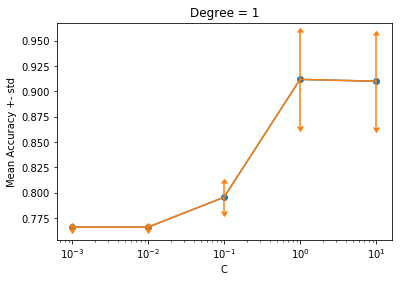

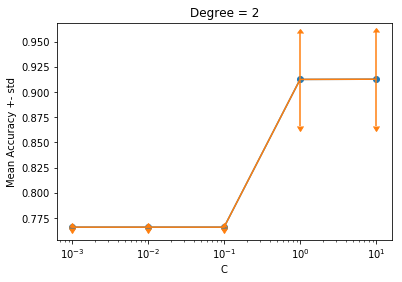

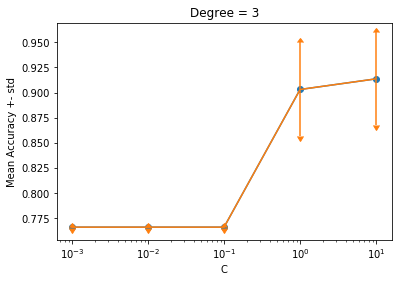

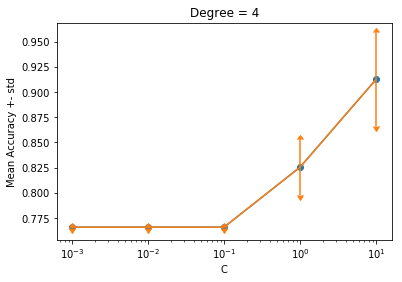

In [0]:
#I here use accuracy as the error term

accuracy_list=[]
for i in range(10):
  accuracy_list.append(pd.DataFrame(grid_search.cv_results_['split'+str(i)+'_test_score']).T)

accuracy_df=pd.concat(accuracy_list,axis=0)

## assign column names
params=grid_search.cv_results_['params']
params_string=['C:'+str(param['C'])+'_'+'degree:'+str(param['degree']) for param in params]
accuracy_df.columns=params_string

mean_array=np.array([np.mean(accuracy_df[column]) for column in accuracy_df.columns])
std_array=np.array([np.std(accuracy_df[column]) for column in accuracy_df.columns])


import matplotlib.pyplot as plt

for d in ds:  
  degree_index=list(np.array([0,4,8,12,16])+d-1)
  plt.plot(Cs,mean_array[degree_index])
  plt.errorbar(Cs, mean_array[degree_index], yerr=std_array[degree_index],lolims=True, uplims=True)
  plt.scatter(Cs,mean_array[degree_index])
  plt.title('Degree = '+str(d))
  plt.xscale('log')
  plt.xlabel('C')
  plt.ylabel('Mean Accuracy +- std')
  plt.show()



#### Best parameters that gives best accuracy:

In [0]:
grid_search.best_params_

{'C': 10, 'degree': 3}

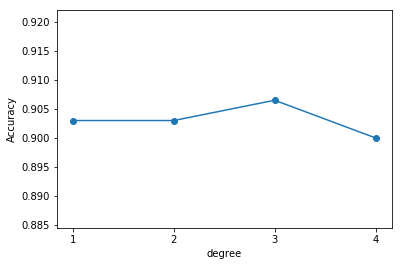

In [0]:
from sklearn.metrics import accuracy_score

ds = [1,2,3,4]
C=10

accuracy_list=[]
no_support_vectors=[]
for d in ds:
  model=SVC(C=C,kernel='poly',degree=d)
  model.fit(X_train_imputed,y_train)
  no_support_vectors.append(model.n_support_) #no of support vectors for each feature 
  accuracy_list.append(accuracy_score(y_test,model.predict(X_test_imputed)))

x=ds
plt.scatter(x,accuracy_list)
plt.plot(x,accuracy_list)
plt.xticks(np.arange(min(x), max(x)+1, 1.0))
plt.xlabel('degree')
plt.ylabel('Accuracy')
plt.show()

In [0]:
no_support_vectors #no. of support vectors for each class (for d=1,2,3,4, respectively)

[array([505, 504], dtype=int32),
 array([525, 520], dtype=int32),
 array([583, 581], dtype=int32),
 array([686, 681], dtype=int32)]

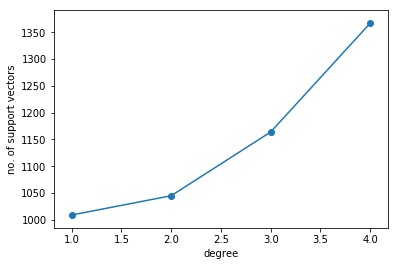

In [0]:
total_no_support_vectors=[]
for d in ds:
  total_no_support_vectors.append(np.sum(no_support_vectors[d-1]))

plt.plot(ds,total_no_support_vectors)
plt.scatter(ds,total_no_support_vectors)
plt.xlabel('degree')
plt.ylabel('no. of support vectors')
plt.show()

Points that lie on the margin hyperplanes should give the decision function f(x)=0

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f51203a9550>]],
      dtype=object)

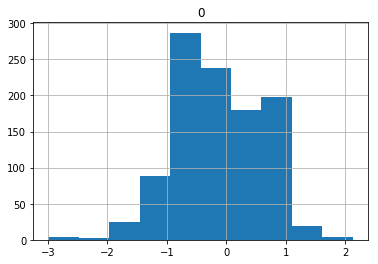

In [0]:
C=10
d=3

model=SVC(C=C,kernel='poly',degree=d)
model.fit(X_train_imputed,y_train)

#ref: https://stackoverflow.com/questions/32074239/sklearn-getting-distance-of-each-point-from-decision-boundary
y = model.decision_function(model.support_vectors_)
pd.DataFrame(y).hist()

In [0]:
np.sum(y==0) #there are many points that are close to the margin (f(x)=0), but there is no points that are exactly on the margin

0

For polynomial kernal: As the parameter d (degree for polynomial kernal) increases, the margin size can be larger (more flexible) and allows more support vectors

For RBF kernal: As the parameter gamma increases, the decision boundary becomes more wiggled (margin size will decrease). In addition, the no. of support vectors will increase

## Q2

![](https://github.com/peterwu19881230/CSCE633_ML_data/raw/master/q2_a_b.png)
![](https://github.com/peterwu19881230/CSCE633_ML_data/raw/master/q2_c_d.png)

Lasso constraint woule have a diamond shape centered at the original of the plane


## Q3

In [0]:
from sklearn.model_selection import train_test_split

df=pd.read_csv('https://raw.githubusercontent.com/peterwu19881230/CSCE633_ML_data/master/hw2_question3.csv') 

print('df shape= ')
print(df.shape)

X=df.iloc[:, [0,1,2,3,4,5,6,7,8]]
response=df.iloc[:, [9]]

y=np.where(np.array(response).astype(int) == 4, 1, 0) #1 means malignant

print('no. of malignant= '+ str(np.sum(y)))
print('no. of benign= '+ str(np.sum(y==0)))

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, random_state=101,stratify=y)

df shape= 
(682, 10)
no. of malignant= 239
no. of benign= 443


There are only ~35% of the data that are malignant (imbalanced data)

### Implement Decision tree

In [0]:
from sklearn.tree import DecisionTreeClassifier

max_depth = list(range(1,31))
criterion=['entropy','gini']
param_grid={'criterion':criterion,'max_depth':max_depth}

grid_search = GridSearchCV(DecisionTreeClassifier(), param_grid, cv=10,scoring='accuracy') # if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used by default
grid_search.fit(X_train, y_train)

GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=DecisionTreeClassifier(class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features=None,
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              presort=False, random_state=None,
                                              splitter='best'),
             iid='warn', n_jobs=None,
             param_grid={'criterion': ['entropy', 'gini'],
                         'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12

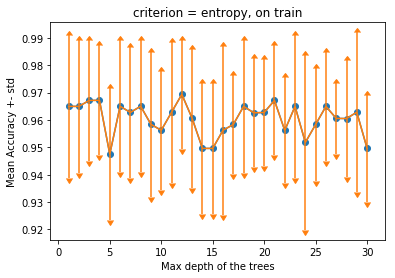

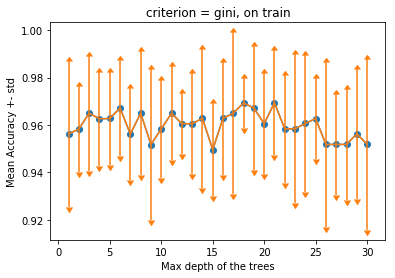

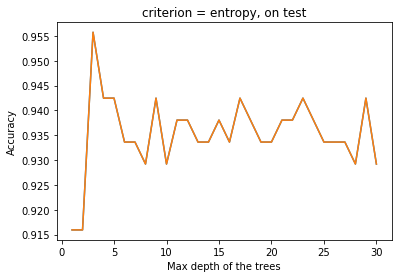

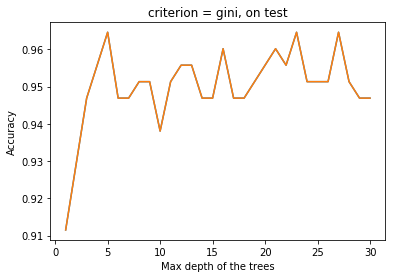

In [0]:
accuracy_list=[]
for i in range(10):
  accuracy_list.append(pd.DataFrame(grid_search.cv_results_['split'+str(i)+'_test_score']).T)

accuracy_df=pd.concat(accuracy_list,axis=0)

## assign column names
params=grid_search.cv_results_['params']
params_string=['criterion:'+str(param['criterion'])+'_'+'max_depth:'+str(param['max_depth']) for param in params]
accuracy_df.columns=params_string

mean_array=np.array([np.mean(accuracy_df[column]) for column in accuracy_df.columns])
std_array=np.array([np.std(accuracy_df[column]) for column in accuracy_df.columns])


# plot based on training data
for i in [0,1]:  
  degree_index=list(np.array(range(1,31))+15*i)
  plt.plot(max_depth,mean_array[degree_index])
  plt.errorbar(max_depth, mean_array[degree_index], yerr=std_array[degree_index],lolims=True, uplims=True)
  plt.scatter(max_depth,mean_array[degree_index])
  plt.title('criterion = '+criterion[i]+', '+'on train')
  plt.xlabel('Max depth of the trees')
  plt.ylabel('Mean Accuracy +- std')
  plt.show()


# plot based on test data

for i in [0,1]:  

  accuracy_list=[]
  for j in max_depth:
    model=DecisionTreeClassifier(criterion=criterion[i],max_depth=j)
    model.fit(X_train,y_train)
    accuracy_list.append(accuracy_score(y_test,model.predict(X_test)))

  degree_index=list(np.array(range(1,31))+15*i)
  plt.plot(max_depth,np.array(accuracy_list))
  plt.plot(max_depth,np.array(accuracy_list))
  plt.title('criterion = '+criterion[i]+', '+'on test')
  plt.xlabel('Max depth of the trees')
  plt.ylabel('Accuracy')
  plt.show()



### Implement Random forest

In [0]:
from sklearn.ensemble import RandomForestClassifier

max_depth = list(range(1,31))
criterion=['entropy','gini']
param_grid={'criterion':criterion,'max_depth':max_depth}

grid_search = GridSearchCV(RandomForestClassifier(), param_grid, cv=10,scoring='accuracy') # if the estimator is a classifier and y is either binary or multiclass, StratifiedKFold is used by default
  #Note: default no. of trees for RandomForestClassifier()= 10

grid_search.fit(X_train, np.array(y_train.ravel())) #I need .ravel() in here for Random Forest but not for Dicision tree


GridSearchCV(cv=10, error_score='raise-deprecating',
             estimator=RandomForestClassifier(bootstrap=True, class_weight=None,
                                              criterion='gini', max_depth=None,
                                              max_features='auto',
                                              max_leaf_nodes=None,
                                              min_impurity_decrease=0.0,
                                              min_impurity_split=None,
                                              min_samples_leaf=1,
                                              min_samples_split=2,
                                              min_weight_fraction_leaf=0.0,
                                              n_estimators='warn', n_jobs=None,
                                              oob_score=False,
                                              random_state=None, verbose=0,
                                              warm_start=False),
             ii

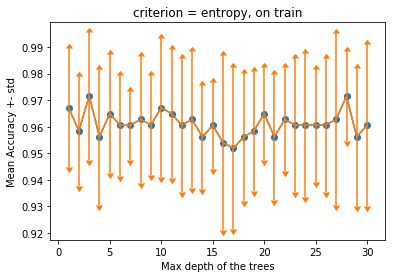

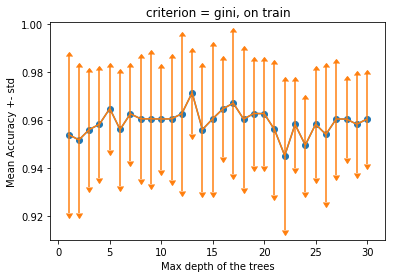

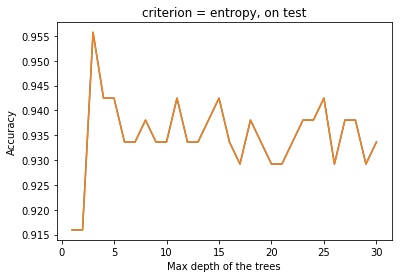

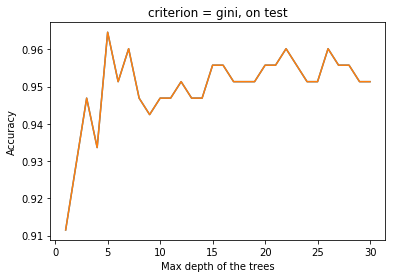

In [0]:
accuracy_list=[]
for i in range(10):
  accuracy_list.append(pd.DataFrame(grid_search.cv_results_['split'+str(i)+'_test_score']).T)

accuracy_df=pd.concat(accuracy_list,axis=0)

## assign column names
params=grid_search.cv_results_['params']
params_string=['criterion:'+str(param['criterion'])+'_'+'max_depth:'+str(param['max_depth']) for param in params]
accuracy_df.columns=params_string

mean_array=np.array([np.mean(accuracy_df[column]) for column in accuracy_df.columns])
std_array=np.array([np.std(accuracy_df[column]) for column in accuracy_df.columns])


# plot based on training data
for i in [0,1]:  
  degree_index=list(np.array(range(1,31))+15*i)
  plt.plot(max_depth,mean_array[degree_index])
  plt.errorbar(max_depth, mean_array[degree_index], yerr=std_array[degree_index],lolims=True, uplims=True)
  plt.scatter(max_depth,mean_array[degree_index])
  plt.title('criterion = '+criterion[i]+', '+'on train')
  plt.xlabel('Max depth of the trees')
  plt.ylabel('Mean Accuracy +- std')
  plt.show()


# plot based on test data

featureImportances=[]
for i in [0,1]:  

  accuracy_list=[]
  for j in max_depth:
    model=DecisionTreeClassifier(criterion=criterion[i],max_depth=j)
    model.fit(X_train,y_train)
    featureImportances.append(model.feature_importances_)
    accuracy_list.append(accuracy_score(y_test,model.predict(X_test)))

  degree_index=list(np.array(range(1,31))+15*i)
  plt.plot(max_depth,np.array(accuracy_list))
  plt.plot(max_depth,np.array(accuracy_list))
  plt.title('criterion = '+criterion[i]+', '+'on test')
  plt.xlabel('Max depth of the trees')
  plt.ylabel('Accuracy')
  plt.show()

In [0]:
# show feature importance rankings (using average of all 60 models based on [gini,entropy] X [1~30 max depth of tree] )

features=['Clump Thickness','Uniformity of Cell Size','Uniformity of Cell Shape','Marginal Adhesion','Single Epithelial Cell Size','Bare Nuclei','Bland Chromatin','Normal Nucleoli','Mitoses']


import scipy.stats as ss
def rank(feature_importance):
  ranking=len(feature_importance) - ss.rankdata(feature_importance,method="max").astype(int)+1
  return(ranking)

ranking_list=[]
importance_list=[]
for i in range(60):
  importance_list.append(pd.DataFrame(featureImportances[i]).T)
  ranking_list.append(pd.DataFrame(rank(featureImportances[i])).T)


ranking_df=pd.concat(ranking_list,axis=0)
importance_df=pd.concat(importance_list,axis=0)
feature_ranking_list=[pd.DataFrame(features),pd.DataFrame(importance_df.mean(axis=0)),pd.DataFrame(ranking_df.mean(axis=0)),pd.DataFrame(ranking_df.std(axis=0))]

feature_ranking_df=pd.DataFrame(pd.concat(feature_ranking_list,axis=1)) 
feature_ranking_df.columns=['features','importance mean','ranking mean','ranking std']
print(feature_ranking_df)

                      features  importance mean  ranking mean  ranking std
0              Clump Thickness         0.111992      2.033333     0.181020
1      Uniformity of Cell Size         0.767551      1.000000     0.000000
2     Uniformity of Cell Shape         0.015073      4.766667     1.319562
3            Marginal Adhesion         0.004198      7.083333     1.576218
4  Single Epithelial Cell Size         0.010265      5.616667     1.151148
5                  Bare Nuclei         0.068001      2.933333     0.251549
6              Bland Chromatin         0.012347      5.216667     1.485428
7              Normal Nucleoli         0.008863      6.116667     1.823497
8                      Mitoses         0.001711      7.716667     1.766848


The rankings were based on the importance of each feature averaged by all the 60 models ( by [gini,entropy] X [1~30 max depth of tree] ). The accuracy doesn't change significantly across different hyperparameters so averaging all of them should be fine. For the final model I would probabily take out 'Marginal Adhesion' and 'Mitosis' because they are the least important. This can be further confirmed by calculating accuracy after post-pruning the trees